# Naive Bayes

## 1. Classifying Digits
In this part we will test digits classification on the MNIST dataset, using Bernoulli Naive Bayes (a generative model), in contrast to the Multivariate Logistic Regression (a discriminative model) we used before.

The MNIST dataset contains 28x28 grayscale images of handwritten digits between 0 and 9 (10 classes). For mathmatical analysis clarity, and for matching expected API, each image faltten to create a 1D array with 784 elements.

### Loading the MNIST dataset
Load the MNIST data set. The digits dataset is one of datasets scikit-learn comes with that do not require the downloading of any file from some external website. Use 
>```
mnist = sklearn.datasets.fetch_mldata('MNIST original')
```

to fetch the original data. You may set the `data_home` to where you wish to download your data for caching. Each image is already transformed into a 1D integer array $x\in [0,255]^{784}$, and the corresponding label is an integer $y\in [0,9]$.

Plot a single sample of each digit as the original image, so you get a feeling how the data looks like.

Finally, divide your data into train and test sets, using 1/7 of the data for testing.

---
**Note 1:** Using `digits = sklearn.datasets.load_digits()` will only fetch a very small sample of the original set, with images resized to 8x8. This preprocessing of the data reduces dimensionality and gives invariance to small distortions - however, we will use the original data in this exercise. Feel free to test the proformance of the algorithms below on the preprocessed data as well.

**Note 2:**
Since ML-Data is deprecated, you may wish to use something like this:
>```
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
  ```



In [11]:
import sklearn
from keras.datasets import mnist
import pandas as pd

### Bernoulli Naive Bayes
If we know how the digits are generated, then we know how to classify them (simply choose the digit class which will maximize the posterior probability) --- but which model should we use for describing the digits generation?

In this part we will try a very simplified model of digits creation (which is obviously not the same as the "real" model), using a Naive Bayes over an underlying Bernoulli distribution --- that is, we will assume that given a digit class, the pixels of the images are the result of independent coin flips, each with its own "head" probability.

Note that since we assume each pixl is either 0 (black) or 1 (white), we will need to adjust (preprocess) our data accrodingly (see below).

So, the model is stated as follows:
$$
\begin{align}
\text{Domain} && x \in \{0,1\}^{784} \\
\text{Prior} && \pi_j = \Pr(y=j) \\
\text{Likelihood} && P_j(x) = \Pr(x | y=j) \\
\end{align}
$$

Where for each $i\in 0\ldots 784$ it holds that
$$
P_{ji}(x_i) = \Pr(x_i | y=j) =
\begin{cases}
p_{ji} & \text{if } x_i=1 \\
1-p_{ji} & \text{if } x_i=0 \\
\end{cases}
$$


In [62]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

#### Question 1
Write the classification rule based on this Naive Bayes model. 
How would you esitmate each of the parameters of the model based on the trainning data? 


**Bonus:** Think of edge cases which may effect your estimator in an undesired way.

#### Answer 1
P(y|x) = P(x|y)P(y) = likelihood * prior

Prior - For each class `i`, just get the number of X_train samples that are of class `i`.<br>
Likelihood - For each of the 784 pixels, we get for each class `i` - how many times there is a 1 divided by the total number of train samples. So for example, if on the the `jth` pixel, there are 300 times that there is a 1 for class `i`, and there are 70000 total examples, so then the P(x_j | y_i) = (300/70000) + (69700/70000) = xi * log(p_ji) + (1 - xi) * log(1 - p_ji)


Because there will be many pixels for every class where none of them will be 1,especially at the literal edges of the images, we will need to use laplacian smoothing.

**Edge Case** - When we have for example a 'One', but it is usually located on the left side of the image, but we have several on the right side of the image. Because the Naive Bayes is only calculating the likelihood pixel by pixel, it will affect the estimator because it will assign likelihoods to regions unfairly and mess up our general model. As long as the edge cases are minimal, it shouldnt cause too much of an issue, especially if our general train data is large.

#### Question 2
Run a Naive Bayes classifier on the training data and apply predictions on the test data. Use the [sklearn.naive_bayes.BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) implementation (see the [source code for sklearn.naive_bayes](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/naive_bayes.py) for details).

Remember we need to preprocess the data in this case such that each pixel would become either black (0) or white (1). For this, use the `binarize` parameter of the implementation. Set this value to $0$ (this is the default), which in this case would mean every pixel with non-zero value will be set to 1.

1. Plot the mean image of each class (estimated $\hat{p}_{ji}$) and generate one sample of each class (remember, you can do this since this is a generative model). You will need to access the `feature_log_prob_` attribute of the trained model.

2. Plot the confusion matrix of your classifier, as claculated on the test data (it is recommended to use [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). Calculate the total accuracy (fraction of correctly classified images), and summarize the results in your own words.

3. Think of a way you can find the optimal threshold of the binarization part. **There is no need to actually perform this task --- just describe what you would have done.**


In [79]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
%matplotlib inline

In [8]:
clf = BernoulliNB(binarize=0).fit(X_train, y_train)

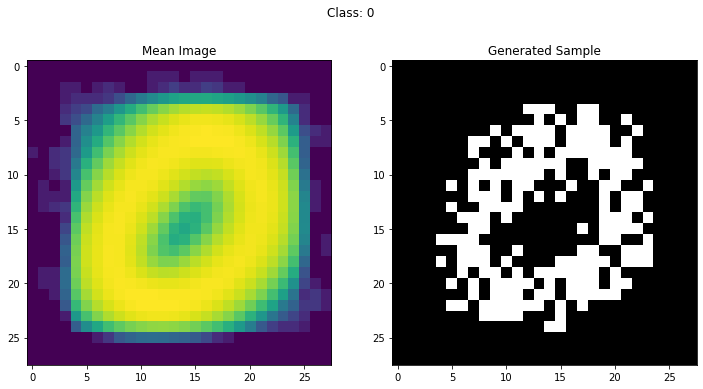

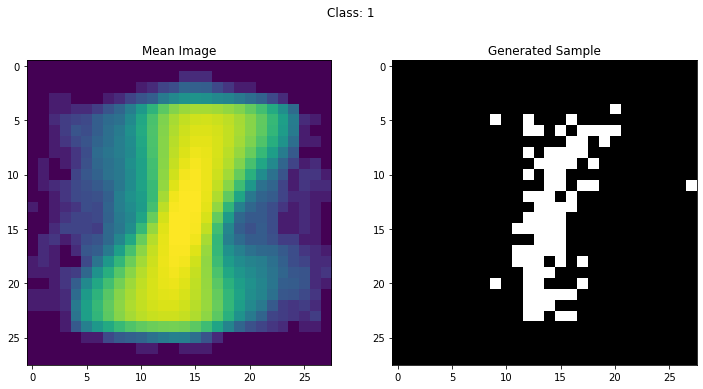

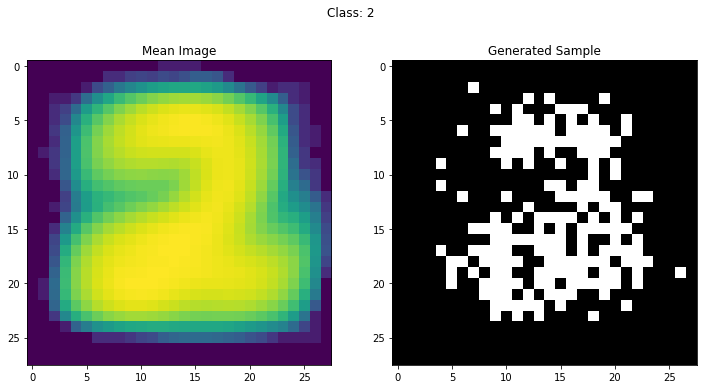

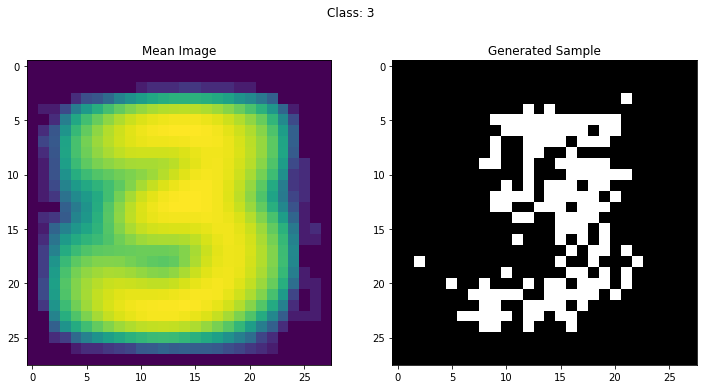

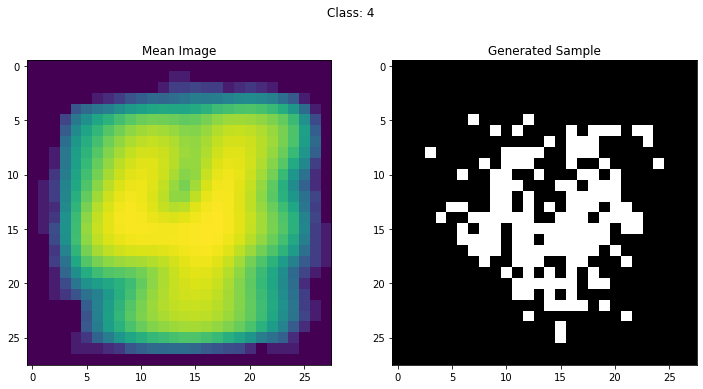

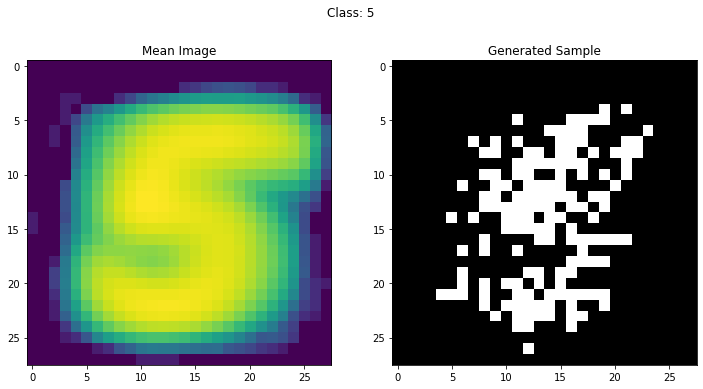

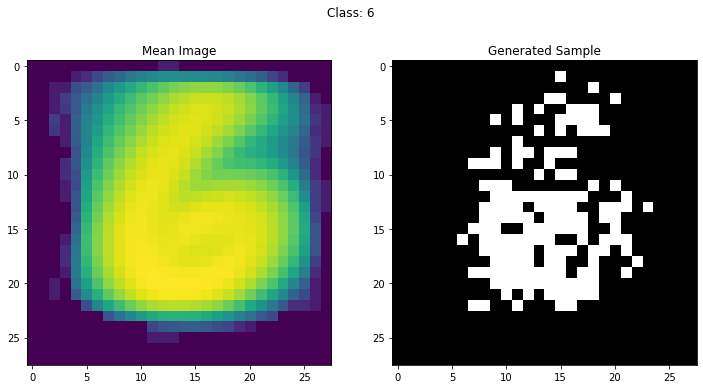

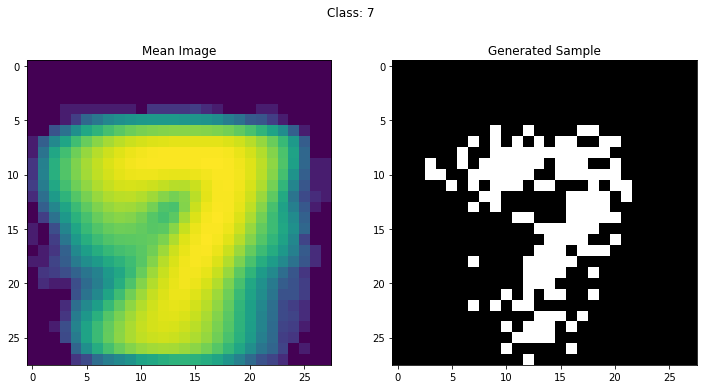

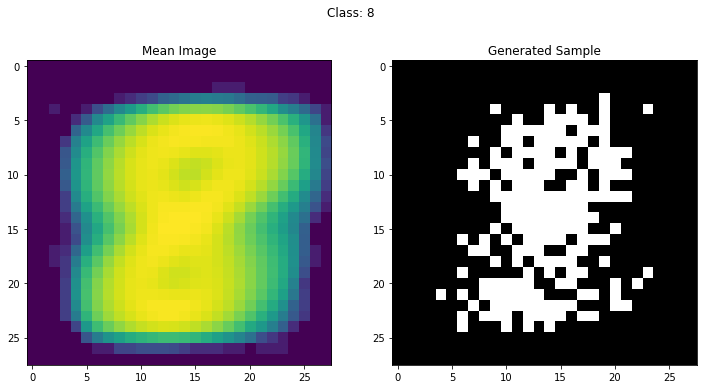

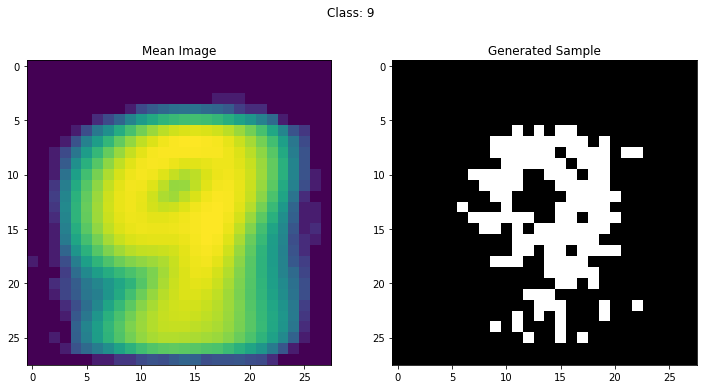

In [80]:
for i in clf.classes_:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle("Class: {}".format(i))
    ax1.imshow(clf.feature_log_prob_[int(i)].reshape(28,28));
    ax1.set_title("Mean Image")
    ax2.imshow(np.random.binomial(1,np.exp(clf.feature_log_prob_[int(i)]),size=(784)).reshape(28,28), cmap="gray")
    ax2.set_title("Generated Sample")
    plt.show()

The accuracy of our confusion matrix is:  0.8413
The accuracy for label 0 is 0.9051
The accuracy for label 1 is 0.9559
The accuracy for label 2 is 0.8256
The accuracy for label 3 is 0.8356
The accuracy for label 4 is 0.8096
The accuracy for label 5 is 0.7029
The accuracy for label 6 is 0.8883
The accuracy for label 7 is 0.8473
The accuracy for label 8 is 0.7782
The accuracy for label 9 is 0.8355


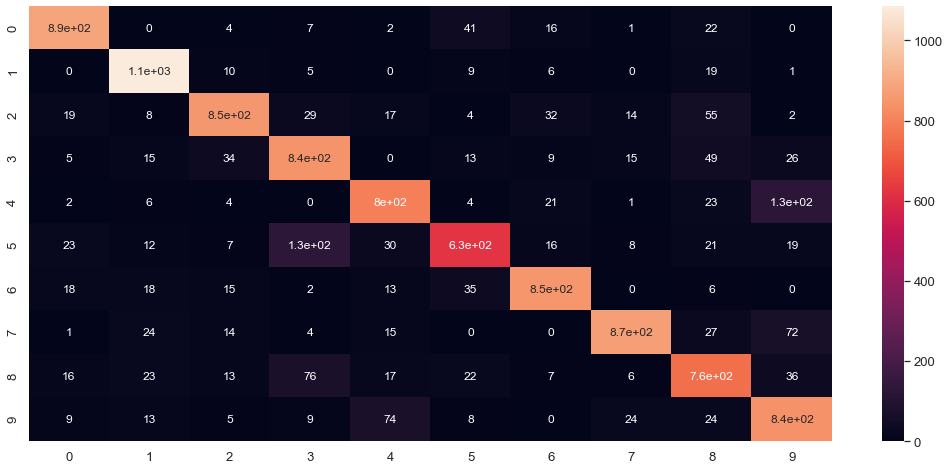

In [12]:
y_pred = clf.predict(X_test)

cfm = np.array(confusion_matrix(y_test,y_pred))
df_cm = pd.DataFrame(cfm, range(10),
                  range(10))
plt.figure(figsize = (18,8))
sns.set(font_scale=1.2)#for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 12})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

#To calculate accuracy:
diagonal_sum = cfm.trace()
sum_of_all_elements = cfm.sum()
print("The accuracy of our confusion matrix is: ", diagonal_sum / sum_of_all_elements)

for i in range(0,10):
    acc_i = np.round(cfm[i,i]/sum(cfm[i,:]),4)
    print("The accuracy for label {} is {}".format(i, acc_i))

Interestingly, comparing this confusion matrix to the one generated with Logistic Regression, although this model performs worse (.83 accuracy as opposed to .92), they both struggle with the same type of mistakes(ex: 3 for 5), although not exactly. Because this model works pixel by pixel, it struggles most when the two numbers have a lot of overlap on a pixel level.
Nevertheless, a .83 accuracy is still pretty decent.

**Q: Think of a way you can find the optimal threshold of the binarization part.<br>A:**
The logic is that at both threshold = 0.0 and 364, they are either overfitting or underfitting, so the solution will be in the middle. <br><br>
As a hyperparameter, we can run CV and find it using Brute Force, but being that it could run from 0-365, we would like to use some heuristic to optimize the search.<br><br>
If I can make the assumption that the graph of the optimal threshold will be a concave parabola, where the local optimum is the global optimum, as such we can easily implement some form of greedy recursive algorithm where we initialize LB = 0 and UB = 365, and MB = UB + LB /2, we then recursively check [UB,MB] and [MB,UB], if we get that MB < LB || MB < UB, we return max(LB,UB), repeat until convergence and return the final max(). For this to be true the sample size must be very large, so that the accuracy isnt dependent on the particular examples used for the train set.

## 2. Classifing Text Documents using Multinomial Naive Bayes
In this exercise you will classify the "20 newsgroups" data set using your own naive bayes classifier and compare to the scikit learn built in version.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon messages posted before and after a specific date.


* Load the **train** data using `from sklearn.datasets import fetch_20newsgroups`. remove headers, footers and quotes (see documentation)
* Use `sklearn.feature_extraction.text import CountVectorizer` to count words (stop_words='english')
* Write a class `NaiveBayes(BaseEstimator, ClassifierMixin)` and implement its `fit`, `predict` and `predict_proba` methods.
* use `sklearn.pipeline.make_pipeline` to chain the vectroizer and model.
* note: limit the vocuabolary size if you suffer memory issues
* compare the accuracy over the **test** data. You can use `accuracy_score, classification_report`
* compare to the built in `sklearn.naive_bayes.MultinomialNB`
* compare to `TfidfVectorizer` preprocessing (you can use the built in model for doing the analysis)
* plot the learning curve - is the model in the bias or variance regime (you can use the built in model for doing the analysis)
* optimize performance in respect to vectorizer hyper parameters (e.g. max_features, max_df etc.).

### Optional: Model interpretability
Find the most important features for a **specific** decision of a NB classifier.
Because the model has learned the prior $p(x_i|c)$ during the training, the contribution of an individual feature value can be easily measured by the posterior, $p(c|x_i)=p(c)p(x_i|c)/p(x_i)$
Implement a function which gets a scikit-learn NB model as input and returns $P(c|x_i)$:

`def calc_p_c_given_xi(model)`

Hint: Use the following model properties:

* `model.class_log_prior_`
* `model.feature_log_prob_`

Note: remember these are logs and you need to use np.exp and normalize to get $P(c|x_i)$ 
Another hint: use numpy built-in broadcasting property.

* Use the interpretation to examine errors of the classifier where $\hat{c}\ne c$. Which top words support the correct class and which support the wrong class? You can use the `print_txt` below to color words. 

Bonus: How can you correct the analyzed error? 

To read more about model interpretation, see the blogpost below and my tutorial:
* https://lilianweng.github.io/lil-log/2017/08/01/how-to-explain-the-prediction-of-a-machine-learning-model.html
* https://github.com/chanansh/right_but_why

In [16]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit, learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import BaseEstimator, ClassifierMixin
from time import time

In [105]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def fit(self, x, y):
        #prior
        self.N_docs = y.size
        self.classes, self.class_sizes = np.unique(y, return_counts=True)
        self.class_priors = self.class_sizes/self.N_docs
        self.class_log_prior_ = np.log(self.class_priors)
        #likelihood
        self.class_vectors = np.array([x[y == c] for c in self.classes])
        self.class_term_freq_ = np.array([np.sum(class_vector.toarray(), axis=0) + 1 
                                            for class_vector in self.class_vectors])
        self.term_freq_ = np.sum(x, axis=0)
        self.feature_term_prob_ = self.class_term_freq_/(self.term_freq_ + x.shape[1])
        self.feature_log_prob_ = np.log(self.feature_term_prob_).copy()
        print(self.feature_log_prob_.shape)
        return self
    def predict_log_proba(self, x):
        return self.class_log_prior_ + np.array(x * self.feature_log_prob.T)
    def predict(self, x):
        return np.argmax(predict_log_proba(x), axis=1)

In [106]:
random_state = 42
shuffle = True
remove = ['headers', 'footers', 'quotes']
data_dict = {}
for subset in ["train", "test"]:
    data = fetch_20newsgroups(subset=subset,
                            shuffle=shuffle, 
                            random_state=random_state,
                            remove=remove)
    data_dict[subset] = data
    n = len(data.data)
    print("{} - {} documents".format(subset, n))
X_train, y_train = data_dict['train'].data, data_dict['train'].target
X_test, y_test = data_dict['test'].data, data_dict['test'].target
target_names = data_dict['train'].target_names
en_stop = list(en_stop)

train - 11314 documents
test - 7532 documents


In [19]:
vectorizer = CountVectorizer(stop_words='english')
tfidfvectorizer = TfidfVectorizer(stop_words='english')
max_df = 0.25

In [35]:
model1 = NaiveBayes()
pipe1 = make_pipeline(vectorizer, model1)
pipe1.fit(X_train, y_train)
pipe_preds1 = pipe1.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, pipe_preds1)}')
conf_matrix1 = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=pipe_preds1), index=target_names)
conf_matrix1.columns = target_names
conf_matrix1;

Accuracy: 0.5622676579925651


,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
alt.atheism,38,0,0,1,0,3,0,0,2,0,13,17,0,5,10,160,4,60,5,1
comp.graphics,0,218,4,9,2,70,2,0,0,0,7,51,0,2,9,5,0,8,2,0
comp.os.ms-windows.misc,2,21,70,50,5,159,1,1,0,0,16,48,1,2,6,4,0,4,4,0
comp.sys.ibm.pc.hardware,0,17,9,234,9,42,5,0,0,0,7,47,14,1,2,1,0,3,1,0
comp.sys.mac.hardware,0,15,9,44,151,43,7,0,0,0,15,59,8,9,12,2,0,11,0,0
comp.windows.x,0,16,2,2,0,335,0,1,0,0,8,17,1,1,6,2,0,3,1,0
misc.forsale,0,3,1,38,8,15,240,6,0,0,12,23,4,4,10,3,1,20,2,0
rec.autos,0,2,4,1,1,11,8,204,7,0,31,32,3,3,21,9,7,38,14,0
rec.motorcycles,1,1,1,1,0,7,5,14,169,1,17,38,9,4,13,19,8,78,12,0
rec.sport.baseball,1,1,0,0,0,9,0,0,1,220,66,16,1,6,4,19,2,42,9,0


In [36]:
model2 = MultinomialNB()
pipe2 = make_pipeline(vectorizer, model2)
pipe2.fit(X_train, y_train)
pipe_preds2 = pipe2.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, pipe_preds2)}')
conf_matrix2 = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=pipe_preds2), index=target_names)
conf_matrix2.columns = target_names
conf_matrix2;

Accuracy: 0.6343600637280935


,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
alt.atheism,97,1,0,1,0,3,0,1,2,1,12,8,0,4,11,130,5,26,11,6
comp.graphics,1,269,0,14,7,35,2,0,0,2,7,26,3,5,7,6,0,3,2,0
comp.os.ms-windows.misc,3,66,2,106,12,131,2,2,1,0,15,32,1,4,4,3,0,2,7,1
comp.sys.ibm.pc.hardware,0,13,0,281,24,20,6,0,0,0,7,18,16,1,1,1,1,2,1,0
comp.sys.mac.hardware,1,20,1,47,216,18,9,3,1,0,15,19,13,8,8,2,0,2,2,0
comp.windows.x,0,32,1,6,4,318,1,0,0,0,8,11,1,2,6,3,0,1,1,0
misc.forsale,0,5,0,38,16,4,268,6,2,2,10,4,8,1,10,5,3,5,3,0
rec.autos,0,2,0,2,1,3,9,278,10,1,29,5,7,2,10,8,11,8,10,0
rec.motorcycles,2,2,0,1,1,2,5,26,245,4,15,10,13,2,3,15,14,19,19,0
rec.sport.baseball,0,3,0,2,0,6,2,0,2,294,34,7,1,5,3,16,2,5,15,0


As we can see, the built-in model performs better than our home-built model, although not to the degree that we were expecting

In [37]:
model3 = NaiveBayes()
pipe3 = make_pipeline(tfidfvectorizer, model3)
pipe3.fit(X_train, y_train)
pipe_preds3 = pipe3.predict(X_test)
print(f'Accuracy: {round(accuracy_score(y_test, pipe_preds3), 3) * 100}%')
conf_matrix3 = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=pipe_preds3), index=target_names)
conf_matrix3.columns = target_names
conf_matrix3;

Accuracy: 67.5%


In [38]:
model4 = MultinomialNB()
pipe4 = make_pipeline(tfidfvectorizer, model4)
pipe4.fit(X_train, y_train)
pipe_preds4 = pipe4.predict(X_test)
print(f'Accuracy: {round(accuracy_score(y_test, pipe_preds4), 3) * 100}%')
conf_matrix4 = pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=pipe_preds4), index=target_names)
conf_matrix4.columns = target_names
conf_matrix4;

Accuracy: 67.80000000000001%


When we vectorize our data using TFIDF the two models perform almost exactly the same. However, performance by class varies significantly, with class 19 having an F1 score of 2% and class 9 having an F1 score of 85%.

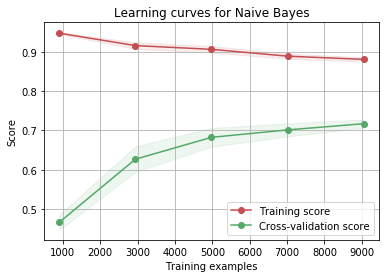

In [112]:
#%%
title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
estimator = NaiveBayes()
train_sizes=np.linspace(.1, 1.0, 5)
plt.title("Learning curves for Naive Bayes")
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = \
    learning_curve(pipe3, X_train, y_train, cv=cv,
                   train_sizes=train_sizes)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
# Plot learning curve
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best");
#%%

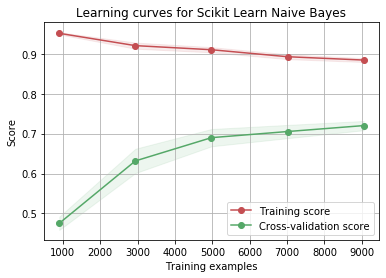

In [113]:
#%%
title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
estimator = MultinomialNB()
train_sizes=np.linspace(.1, 1.0, 5)
plt.title("Learning curves for Scikit Learn Naive Bayes")
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = \
    learning_curve(pipe4, X_train, y_train, cv=cv,
                   train_sizes=train_sizes)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
# Plot learning curve
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best");
#%%

We can see that the model is low bias since it performs well on the training set, but it doesn't generalize well meaning it has high variance. However, we do see that the Training and CV scores converge as we add training examples, menaing that this algorithm would benefit from more data.

In [115]:
parameters = {
    'tfidfvectorizer__max_df': (0.25, 0.5, 0.75, 1.0),
    'tfidfvectorizer__max_features': (None, 10000, 50000),
}
t0 = time()
grid_search = GridSearchCV(pipe3, parameters, verbose=1)
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

C:\Users\shaul\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.4min finished


done in 151.623s

Best score: 0.708
Best parameters set:
	tfidfvectorizer__max_df: 0.25
	tfidfvectorizer__max_features: None


After running the GridSearch CV with Multinomial NB we found the parameters above, however running the model with said parameters doesn't actually improve the performance over the default settings by any measurable margin

In [116]:
tfidfvectorizer = TfidfVectorizer(stop_words='english',max_df=0.25,max_features=None)
model5 = NaiveBayes()
pipe5 = make_pipeline(tfidfvectorizer, model3)
pipe5.fit(X_train, y_train)
pipe_preds5 = pipe5.predict(X_test)
print(f'Accuracy: {round(accuracy_score(y_test, pipe_preds5), 3) * 100}%')

Accuracy: 67.5%


***Optional: Model interpretability***

In [117]:
def calc_p_c_given_xi(model):
    p_c = np.exp(model.class_log_prior_)
    p_w_c = np.exp(model.feature_log_prob_)
    p_c_w = p_c.reshape(-1,1) * p_w_c
    p_c_w = p_c_w/p_c_w.sum(axis=0)
    return p_c_w
p_c_w = calc_p_c_given_xi(model4)

In [118]:
x = vectorizer.transform(X_test)
idx2word={v:k for k, v in vectorizer.vocabulary_.items()}
cold_color='\x1b[41;37m{}\x1b[0m'
hot_color='\x1b[42;37m{}\x1b[0m'
mid_color='\x1b[45;37m{}\x1b[0m' 
def word_by_score(c, word_index, min_p=0.1, max_n=10):
    """
    return a pandas series with index being the word and its index and the value being p(c|xi)
    """
    word_score = p_c_w[c, word_index]
    words =[idx2word[w] for w in word_index]
    s = pd.Series(word_score.flatten(), index=[words, word_index])
    s.index.names=['word','idx']
    s.name = 'score'
    stop = s.sort_values(ascending=False)
    stop = stop[stop>min_p]
    if len(stop)>max_n:
        stop = stop[:max_n]
    return stop.reset_index()

In [119]:
import string
def print_txt(txt, hot, cold):
    """
    print the text, coloring hot and cold words with colors
    """
    def color(token):
        lower = str(token).lower()
        lower = lower.replace('\t','').replace('\n','')
        lower = lower.translate(string.punctuation)
        if (lower in hot) and (lower in cold):
            return mid_color.format(token)
        elif lower in hot:
            return hot_color.format(token)
        elif lower in cold:
            return cold_color.format(token)
        else:
            return token
    colored_txt = " ".join([color(token) for token in txt.split(' ')])
    print(colored_txt)

In [120]:
def display_doc(i, pred):
    """
    displaying document i
    """
    c_hat = pred[i]
    c = y_test[i]
    txt = X_test[i]
    xi = x[i,:]
    nz = xi.nonzero()[1] # non zero words

    print('')
    print('document={}, c={} ({}), guess correctly = {}'.format(i, c, target_names[c], c_hat==c))
    print('-'*80)
    hot = word_by_score(c,nz)
    print(hot)
    hot_words = hot.word.tolist()
    if c_hat!=c:
        print('-'*80)
        print('score for incorrect guess c_hat={} ({})'.format(c_hat, target_names[c_hat]))
        print('-'*80)
        cold = word_by_score(c_hat,nz)
        cold_words = cold.word.tolist()
        print(cold)
    else:
        cold_words = []
    print('-'*80)
    print('text:')
    print('-'*80)
    print_txt(txt, hot_words, cold_words)

In [124]:
i = 349
display_doc(i, pipe_preds2)


document=349, c=4 (comp.sys.mac.hardware), guess correctly = False
--------------------------------------------------------------------------------
      word    idx     score
0  printer  73017  0.103287
--------------------------------------------------------------------------------
score for incorrect guess c_hat=1 (comp.graphics)
--------------------------------------------------------------------------------
          word    idx     score
0   postscript  72329  0.147143
1      looking  57250  0.130937
2  appreciated  19162  0.108159
--------------------------------------------------------------------------------
text:
--------------------------------------------------------------------------------
I'm looking for recommendations for a laser printer.  It will
be used mostly for text by a single user.  It doesn't need to
be a postscript printer.  Any advice would be appreciated.



**Bonus: How can you correct the analyzed error?**

You run through a validate data set and record all the words that led us to the wrong class (above a certain threshold), we can then add those words to the stop words.